## What started as a sheet for generators turned into a study of collections relative to pandas.

In [1]:
import math, json, collections, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
%matplotlib inline

### Here we check the timing between pd.read_table() and open() --> assign to a Medal object

In [3]:
file = "goldmedals.txt"

#Using Dataframes
df = pd.read_table(file,header=None, names=['year','athlete','team','event'],)
def clean_event_df(names: List[str]):
    return [' '.join(word for word in name.split() if word not in ['men', 'women']) for name in names]
df['event'] = clean_event_df(df['event'].values)
top_athletes_from_df = df.groupby('athlete').nunique()

# Using collections
Medal = collections.namedtuple('medal',['year','athlete','team','event'])
medals = [Medal(*line.strip().split('\t')) for line in open(file, 'r')]
def howmany(tup):
    return len(tup[1])
def clean_event(name):
    return ' '.join(word for word in name.split() if word not in ['men', 'women'])
d = collections.defaultdict(set)
for medal in medals:
    d[medal.athlete].add(clean_event(medal.event))
top_athletes_from_collections = sorted(d.items(), key=howmany, reverse=True)

### Pandas flexibility vs object immutability.
### Turns out the namedtuple import is a bit faster... almost twice as fast.
#### (Need to test with both smaller and larger datasets.)

In [4]:
%%timeit
file = "goldmedals.txt"
df = pd.read_table(file,header=None, names=['year','athlete','team','event'],)

2.95 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
%%timeit
file = "goldmedals.txt"
Medal = collections.namedtuple('medal',['year','athlete','team','event'])
medals = [Medal(*line.strip().split('\t')) for line in open(file, 'r')]

1.33 ms ± 19.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Next we need to clean data(clean_event()) and count athletes who have won gold medals in different events.
#### Vectorized cleaning is fastest

In [6]:
%%timeit
def clean_event_df(names: List[str]):
    return [' '.join(word for word in name.split() if word not in ['men', 'women']) for name in names]

#running the clean_event on the vector of values rather than on each individual item is MUCH faster.
df['event'] = clean_event_df(df['event'].values)

1.03 ms ± 8.99 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
%%timeit
def howmany(tup):
    return len(tup[1])
def clean_event(name):
    return ' '.join(word for word in name.split() if word not in ['men', 'women'])

d = collections.defaultdict(set)

for medal in medals:
    d[medal.athlete].add(clean_event(medal.event))

1.53 ms ± 21.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Now it's time to do the counting... here, of course, collections significantly outperforms pd.

In [8]:
%%timeit
df.groupby('athlete').nunique()
# df.pivot_table(values='team', index='event', columns='athlete', aggfunc='nunique').sum().sort_values(ascending=False)
# The pivot table performs unnecessary operations and is slower than the groupby

3.38 ms ± 80.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
%%timeit
sorted(d.items(), key=howmany, reverse=True)

154 µs ± 3.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Other collections are quite a bit faster (almost a factor of 4) relative to groupby

In [10]:
%%timeit
df.groupby('team')['year'].count().sort_values(ascending=False)[:5]

681 µs ± 5.28 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
%%timeit
teams = collections.Counter(medal.team for medal in medals)
teams.most_common(5)

183 µs ± 3.35 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Here I'm playing with plots... not sure how it compares to plotting directly from pandas

In [12]:
plt.style.use('ggplot')

def best_by_year(year, top):
    counts = collections.Counter(medal.team for medal in medals if medal.year == str(year))
    best = counts.most_common(top)
    return [b[0] for b in best], [b[1] for b in best]

def plotyear(year, top):
    colors = plt.cm.Set3(np.linspace(0,1,top))
    countries, tally = best_by_year(year, top)
    #plt.figure(figsize=(6,3))
    bars = plt.bar(np.arange(top), tally, align='center')
    plt.xticks(np.arange(top), countries)
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    plt.title(year)

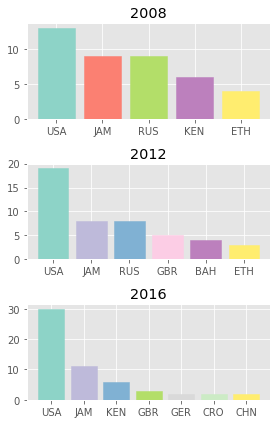

In [13]:
plt.figure(figsize=(4,6))
plt.subplot(3,1,1); plotyear(2008, 5)
plt.subplot(3,1,2); plotyear(2012, 6)
plt.subplot(3,1,3); plotyear(2016, 7)
plt.tight_layout()

### Finally... playing with kwargs in collections.
#### This is worth spending more time

In [14]:
def find_medal(**kwargs):
    return [medal for medal in medals
                  if all(getattr(medal,key, None) == value
                         for key, value in kwargs.items())]

In [15]:
find_medal(athlete='Carl Lewis')

[medal(year='1984', athlete='Carl Lewis', team='USA', event='100m men'),
 medal(year='1984', athlete='Carl Lewis', team='USA', event='200m men'),
 medal(year='1984', athlete='Carl Lewis', team='USA', event='4x100m relay men'),
 medal(year='1984', athlete='Carl Lewis', team='USA', event='long jump men'),
 medal(year='1988', athlete='Carl Lewis', team='USA', event='100m men'),
 medal(year='1988', athlete='Carl Lewis', team='USA', event='long jump men'),
 medal(year='1992', athlete='Carl Lewis', team='USA', event='4x100m relay men'),
 medal(year='1992', athlete='Carl Lewis', team='USA', event='long jump men'),
 medal(year='1996', athlete='Carl Lewis', team='USA', event='long jump men')]